In [1]:
import qutip
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import pickle
import time as time
import math, cmath
import sys
import auxiliary_library as me

from IPython.display import display, Math, Latex

In [2]:
### 1. armar un test que chequee que la base sea ortonormal y hermÃ­tica y que den 
       ## reales los productos. 
### 2. chequar que la semilla y la identidad no cambien en lo posible.
### 3. fijarse de agregar un coeficiente inicial a la base que acompaÃ±e a la identidad global 
### 4. 

display(Latex(f'$\\langle \\sigma^x_0 \\sigma^x_1 \\rangle^\\rho = .5 Tr \\bigg(\\rho (A^\\dagger A + A A^\\dagger)\\bigg)$')) 

<IPython.core.display.Latex object>

In [52]:
N = 3
basis_depth = 3

spin_ops_list = me.one_body_spin_ops(N)
globalid = spin_ops_list[0][0]
normalized_globalid = globalid/globalid.tr()

chain_type = "XYZ"
Hamiltonian_paras = [.1, .15, .2, 1.]
H_H = me.Heisenberg_Hamiltonian(spin_ops_list, "XYZ", N, False, Hamiltonian_paras)

### Hypothesized final density state

sx0sx1 = spin_ops_list[1][0] * spin_ops_list[1][1]

if qutip.isherm(sx0sx1):
    print("Seed operator is hermitian")
else:
    print("Seed operator not hermitian")

x = .4
K = (x * sx0sx1 + (1-x) * globalid)
rhoF = K.expm()
rhoF = rhoF/rhoF.tr()
inv_rhoF = (-K).expm()
inv_rhoF = inv_rhoF/inv_rhoF.tr()

if (me.is_density_op(rhoF)):
    pass
else:
    sys.exit("rhoF is not a density op") 
    
if (me.is_density_op(inv_rhoF)):
    pass
else:
    sys.exit("inv_rhoF is not a density op") 

### Checking if the sx0sx1's rhoF-weighted average is zero:

print("<sx0sx1>_rhoF = ", (rhoF * sx0sx1).tr())

### It is not, so then I redefine it so that it has zero rhoF-weighted average

sx0sx1 = (rhoF * sx0sx1).tr() - sx0sx1

print("<new(sx0sx1)>_rhoF = ", (rhoF * sx0sx1).tr())

### Then, the seed operator has zero rhoF-weighted average and sigma=1-standard deviation.
### It's then chosen to be the seed operator

seed_op = sx0sx1
basis = []
basis.append(seed_op)
basis.append(globalid)

basis += me.recursive_basis(N, basis_depth, H_H, seed_op, rhoF)
print("At this step, the (non-orthonormal)-basis has", len(basis), "non-zero operators")

mk_basis = me.base_orth(basis, rhoF)

print("At this step, the orthonormal-basis has", len(mk_basis), "non-zero operators")

gram_matrix = me.basis_orthonormality_check(mk_basis, rhoF)

for i in range(len(mk_basis)):
    print("<rhoF * mk_basis[", i, "] > = ",(mk_basis[i] * rhoF).tr())

hij_tensor = me.H_ij_matrix(H_H, mk_basis, rhoF)[1]

Seed operator is hermitian
<sx0sx1>_rhoF =  0.02491699865623895
<new(sx0sx1)>_rhoF =  0.0
At this step, the (non-orthonormal)-basis has 5 non-zero operators
At this step, the orthonormal-basis has 4 non-zero operators
Not mean-normalized operator at 1 -th level
1.0
The basis is orthonormal
<rhoF * mk_basis[ 0 ] > =  0.0
<rhoF * mk_basis[ 1 ] > =  1.0
<rhoF * mk_basis[ 2 ] > =  6.938893903907228e-18j
<rhoF * mk_basis[ 3 ] > =  3.469446951953614e-18


In [46]:
qutip.Qobj(hij_tensor)

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[-3.46944695e-18+0.j          0.00000000e+00+0.j
   0.00000000e+00-4.43799571j -5.20417043e-18+0.j        ]
 [-4.16333634e-17+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.44453961j -2.77555756e-17+0.j        ]
 [ 0.00000000e+00+4.4825238j   0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+4.49138742j]
 [ 0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00-4.49138742j  6.77626358e-21+0.j        ]]

In [48]:
from scipy.integrate import odeint

def F(y, t, H_tensor):
    return H_tensor.dot(y)

In [51]:
hij_tensor.dot(Phi0_vec)

array([-1.73472348e-18+0.j       , -2.08166817e-17+0.j       ,
        0.00000000e+00+2.2412619j,  0.00000000e+00+0.j       ])

In [50]:
from scipy.integrate import ode

zero_list = [0 for i in range(len(mk_basis) - 1)]
Phi0_vec = [.5] + zero_list

t0 = 0
ts=np.linspace(0,1,200)
r = ode(F).set_integrator('zvode', method='bdf', with_jacobian=None)
r.set_initial_value(Phi0_vec, t0).set_f_params(2.0).set_jac_params(2.0)

t1 = 10
dt = 1

while r.successful() and r.t < t1:
    r.integrate(r.t+dt)
    print(r.t, r.y)

#result = complex_ode(func=F, y0=Phi0_vec,t=ts,args=(hij_tensor,))
#plt.figure(figsize=(4, 3))

#for i in range(len(markov_basis)):
#    plt.plot(result[i], label=r'$\phi_{(%d)}(t)$'%i)

#plt.plot(r)

#plt.xlabel("t")
#plt.ylabel("Phi(t)")
#plt.legend()

AttributeError: 'float' object has no attribute 'dot'

In [38]:
r[0]

In [104]:
rhos_at_timet = []

for i in range(len(result)):
    loc_K = sum([result[i][a] * mk_basis[a] for a in range(len(mk_basis))])
    rhos_at_timet.append(loc_K.expm())
    loc_K = 0

In [12]:
for i in range(len(rhos_at_timet)):
    print(me.is_density_op(rhos_at_timet[i]))
    #print(me.ev_checks(rhos_at_timet[i]))
    pass

NameError: name 'rhos_at_timet' is not defined

In [114]:
for i in range(len(rhos_at_timet)):
    if (me.is_density_op(rhos_at_timet[i])):
        print("At time =", i, "density op")
    else:
        pass
        #print("At time =", i, "not density op")

At time = 0 density op


In [61]:
N = 4
depth = 3

K = .5*seed_op2
rho0 = K.expm()
rho0 = rho0/rho0.tr()


spin_ops_list = me.one_body_spin_ops(N)
N_site_globalid = 
Mz = sum(spin_ops_list[3][i] for i in range(N))
Sx0Sx1 = HS_normalize_op(spin_ops_list[1][0]*spin_ops_list[1][0+1] + spin_ops_list[1][1]*spin_ops_list[1][0], rho0)
Sx0Sx1 = Sx0Sx1 - (Sx0Sx1 * rho0).tr() * N_site_globalid


chain_type = "XYZ"
Hamiltonian_paras = [.1, .15, .2, 1.]
H_H = me.Heisenberg_Hamiltonian(spin_ops_list, "XYZ", N, False, Hamiltonian_paras)

basis = []
basis.append(N_site_globalid/np.sqrt(me.mod_HS_inner_prod(N_site_globalid, N_site_globalid)))
basis += me.recursive_basis(N, depth, H_H, seed_op2)
#mk_basis = [.5 * basis[a] + basis[a].dag() for a in range(len(basis))]
mk_basis = me.base_orth(basis, rho0)

#for i in range(len(mk_basis)):
#A = [me.mod_HS_inner_prod(mk_basis[3], mk_basis[a], rho0) for a in range(len(mk_basis))]
#A

# acÃƒÂ¡ un temita: 
# 1. yo me defino el estado inicial con algÃƒÂºn seed operator
# 2. pero despuÃƒÂ©s yo me cambio el seed operator cuando haga la ortonormalizaciÃƒÂ³n de GS

hij_tensor = me.H_ij_matrix(H_H, mk_basis, rho0)

# Operadores no hermÃƒÂ­ticos. Veo de hacerlos hermÃƒÂ­ticos la fuerza

In [7]:
def bures(rho, sigma):
    if (me.is_density_op(rho) and me.is_density_op(sigma)):
        val1 = abs((me.sqrtM(rho)*me.sqrtM(sigma)).tr())
        val1 = max(min(val1,1.),-1.)
        val1 = np.arccos(val1)/np.pi
    else: 
        sys.exit("Singular input matrix")
    return val1

rho1 = (.4*Sx0Sx1).expm()
rho1 = rho1/rho1.tr()
bures(rho0, rho1)

0.007759750761890424

In [9]:
bures_distance_list = [bures(rho0, resultsB["State ev"][a]) for a in range(len(resultsB["State ev"]))]

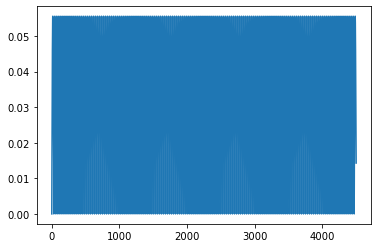

In [10]:
plt.plot(bures_distance_list)

In [8]:
bures(rho0, resultsB["State ev"][4499])

0.01428582964910818

Processing custom initial state
Quantum object: dims = [[2, 2, 2, 2], [2, 2, 2, 2]], shape = (16, 16), type = oper, isherm = True
Qobj data =
[[0.0625   0.       0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.015625 0.       0.       0.      ]
 [0.       0.0625   0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.       0.015625 0.       0.      ]
 [0.       0.       0.0625   0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.       0.       0.015625 0.      ]
 [0.       0.       0.       0.0625   0.       0.       0.       0.
  0.       0.       0.       0.       0.       0.       0.       0.015625]
 [0.       0.       0.       0.       0.0625   0.       0.       0.
  0.015625 0.       0.       0.       0.       0.       0.       0.      ]
 [0.       0.       0.       0.       0.       0.0625   0.       0.
  0.       0.015625 0.       0.       0.       0.       0.       0.      ]


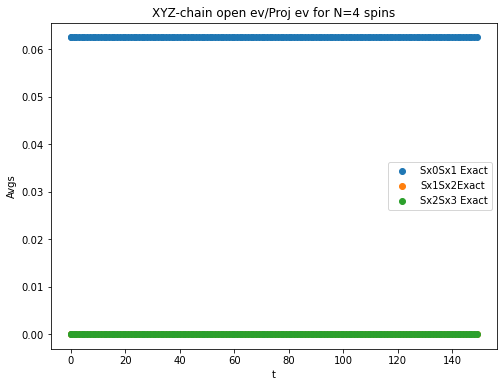

In [118]:
start_time = time.time()
unitary_ev = False; gamma = 3*np.pi**-1
size = N; gaussian = True; gr = 2; xng = .7

spin_ops_list = me.one_body_spin_ops(size)
seed_op1 = Mz = sum(spin_ops_list[3][i] for i in range(size))
seed_op2 = Sx0Sx1 = spin_ops_list[1][0]*spin_ops_list[1][0+1] + spin_ops_list[1][1]*spin_ops_list[1][0] 

NN_interactions_on_x = [spin_ops_list[1][a]*spin_ops_list[1][a+1] for a in range(N-1)] 
NN_interactions_on_x + [spin_ops_list[1][N-1]*spin_ops_list[1][0]] 

obs_basis = NN_interactions_on_x
rho0 = (qutip.tensor([qutip.qeye(2) for k in range(N)]) + .5*seed_op2)
rho0 = rho0/rho0.tr()

chain_type = "XYZ"

title, ev_paras, resultsB = me.spin_chain_ev(size = size, init_state = rho0, chain_type = chain_type, 
                                             Hamiltonian_paras = Hamiltonian_paras, omega_1=3., omega_2=3., 
                                             temp=1, tmax = 150, deltat = 1, two_body_basis = True, 
                                             unitary_ev = unitary_ev, gamma = gamma, gaussian = gaussian, 
                                             gr = gr, xng = xng, obs_basis = obs_basis, do_project = False)

print("--- %s seconds ---" % (time.time() - start_time))

ev_paras["Time elapsed"] = time.time() - start_time

plt.figure(figsize=(8, 6))
plot_labels = ["Sx0Sx1 ", "Sx1Sx2 ", "Sx2Sx3 ", "Sx3Sx0 "]

for n in range(N-1):
    plt.scatter(resultsB["ts"], resultsB["averages"][:,n], label=plot_labels[n] + "Exact")
    
plt.xlabel("t")
plt.ylabel("Avgs")
plt.title(title)
plt.legend()

In [124]:
basis = mk_basis
basis[0] == Sx0Sx1
basis[1] == me.commutator(H_H, Sx0Sx1)
basis[2] == me.commutator(H_H, me.commutator(H_H, Sx0Sx1))
basis[3] == me.commutator(H_H, me.commutator(H_H, me.commutator(H_H, Sx0Sx1)))
basis[4] == me.commutator(H_H, me.commutator(H_H, me.commutator(H_H, me.commutator(H_H, Sx0Sx1))))

True

In [ ]:
<O>(t)

d/dt <O> = <[H,O]>
d/dt <[H,O]> = <[H, [H,O]]>
d/dt <[H,[H,O]]> = <[H, [H,[H,O]]>
